# Overwiev and Exploration of Unprocessed Data
Robin Feldmann


<hr/>

This section aims to provide a generall understanding of the unprocessed data. Folowing questions aim to be answered:

    1. How many tweets are provided?
    2. Which timespan is covered by the data?
    2. How many tweets are provided distributed over time?
    3. How many tweets are provided in each language?
    4. How many tweets are provided in each language distributed over time?
    5. How many tweets are duplicated on the same day?
    6. How many tweets are duplicated on the same day distributed over time?
    7. How many tweets are duplicated on the same day distributed over languages?

Those insights are necessary to prepare for further processing steps like deciding which data to keep and or translate.

<hr/>

### Imports and settings

In [129]:
import pandas as pd
import numpy as np
import warnings
from typing import Dict, Iterator, Any
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
import os
from tqdm.auto import tqdm
# register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()
from enum import StrEnum
import math
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

### Functionality for aggregating and loading the data

In [69]:
def iterate_dataframes(path: str) -> Iterator[pd.DataFrame]:
    """
    Iterates over all .csv files in path as pd.DataFrame
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
        csvs = [path + x for x in os.listdir(path) if "csv" in x]
    
        for csv in tqdm(csvs):
            yield pd.read_csv(csv,  lineterminator='\n')

def aggregate_dataframe(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Aggregates dataframe to dict.
    """
    df_la = df.groupby("language").count().reset_index()
    languages = df_la['language'].tolist()
    lang_counts = df_la['username'].tolist()
    df['dupl'] = df.duplicated(subset="text") if not 'is_retweet' in df.columns else df.duplicated(subset="text") | df['is_retweet']
    languages_dupl = [la + "_dupl" for la in languages]
    lang_dupl_counts = df.groupby("language")['dupl'].sum().tolist()
    unique_user_count = df['userid'].unique().shape[0]
    row_count = df.shape[0]
    duplicated_count = df.duplicated(subset="text").sum()
    date = df.iloc[0]['tweetcreatedts'][:10]
    aggregation = {'unique_users': unique_user_count,
                  'row_count': row_count,
                  'text_duplicated_count': duplicated_count,
                  'date':date}
    aggregation = {**dict(zip(languages, lang_counts)), **aggregation, **dict(zip(languages_dupl, lang_dupl_counts))}
    return aggregation
    

def aggregate_data(dir_path: str, target_path: str) -> pd.DataFrame:
    """
    Creates aggregated data frame and saves it as csv.
    """

    agg_dicts = []
    for df in iterate_dataframes(dir_path):
        agg = aggregate_dataframe(df)
        agg_dicts.append(agg)
    df_agg = pd.DataFrame(agg_dicts).fillna(0)
    df_agg.to_csv(target_path)
    

def get_all_aggregated_data() -> pd.DataFrame:
    """
    Loads or creates all aggregated data.
    """
    path_2023 = "/Users/robinfeldmann/TopicAnalysisRUWTweets/Data/2023_agg.csv"
    path_2022 = "/Users/robinfeldmann/TopicAnalysisRUWTweets/Data/2022_agg.csv"

    df_agg_2023 = pd.read_csv(path_2023)
    df_agg_2022 = pd.read_csv(path_2022)

    df_agg = df_agg = pd.concat([df_agg_2022,df_agg_2023]).fillna(0)
    return df_agg

### Create or load aggregated data

In [70]:
path_2023 = "/Users/robinfeldmann/TopicAnalysisRUWTweets/Data/2023_agg.csv"
path_2022 = "/Users/robinfeldmann/TopicAnalysisRUWTweets/Data/2022_agg.csv"
path_2023_data = "/Users/robinfeldmann/TopicAnalysisRUWTweets/Data/2023/"
path_2022_data = "/Users/robinfeldmann/TopicAnalysisRUWTweets/Data/2022/"
aggregate_data(path_2023_data, path_2023)
aggregate_data(path_2022_data, path_2022)

df_agg = get_all_aggregated_data()

100%|██████████████████████████████████████| 311/311 [11:52<00:00,  2.29s/it]


### Functionality for data exploration

In [134]:
class DataSchema(StrEnum):
    USERS = "unique_users"
    ROWS = "row_count"
    DUPLICATED = "text_duplicated_count"
    DATE = "date"
    OTHERS = "others"

languages = np.array(['am', 'ar', 'bg', 'bn', 'ca', 'ckb', 'cs', 'cy', 'da', 'de', 'dv', 'el',
       'en', 'es', 'et', 'eu', 'fa', 'fi', 'fr', 'gu', 'hi', 'ht', 'hu', 'hy',
       'in', 'is', 'it', 'iw', 'ja', 'ka', 'kn', 'ko', 'lt', 'lv', 'ml', 'mr',
       'my', 'ne', 'nl', 'no', 'or', 'pa', 'pl', 'ps', 'pt', 'ro', 'ru', 'si',
       'sl', 'sr', 'sv', 'ta', 'te', 'th', 'tl', 'tr', 'uk', 'und', 'ur', 'vi',
       'zh','sd', 'km', 'lo', 'ug', 'bo'])

languages_dupl = np.array([la + "_dupl" for la in languages])
language_counts = np.array([df_agg[la].sum() for la in languages])

languages = languages[np.argsort(language_counts)[::-1]]
language_counts = language_counts[np.argsort(language_counts)[::-1]]
language_freqs = np.array([la_count/language_counts.sum() for la_count in language_counts])

language_dupl = np.array([df_agg[la+ "_dupl"].sum() for la in languages])


language_counts = [df_agg[la].sum() for la in languages]
language_freq = np.array([la_co/sum(language_counts) for la_co in language_counts])
selected_lang = languages[language_freq > 0.01]
not_selected_languages =languages[~(language_freq > 0.01)]

df_agg['others'] = df_agg.apply(lambda x: sum([x[other] for other in not_selected_languages]), axis = 1)
df_agg['others_dupl'] = df_agg.apply(lambda x: sum([x[other+"_dupl"] for other in not_selected_languages]), axis = 1)
selected_lang = np.append(selected_lang,'others')


In [83]:
selected_lang

array(['en', 'und', 'de', 'fr', 'it', 'es', 'uk', 'ru', 'tr', 'others'],
      dtype='<U6')

### Exploration in Numbers

In [73]:
print(f"Tweets total: {df_agg[DataSchema.ROWS].sum()}.")
print(f"First date: {df_agg[DataSchema.DATE].min()}.  Last date: {df_agg[DataSchema.DATE].max()}. Unique dates: {df_agg[DataSchema.DATE].unique().shape[0]}.")
print(f"Tweets duplicated on the same day total: {df_agg[DataSchema.DUPLICATED].sum()}. Tweets duplicated on the same day percent: {df_agg[DataSchema.DUPLICATED].sum()/df_agg[DataSchema.ROWS].sum() :.2%}" )

Tweets total: 70885956.
First date: 2022-02-24.  Last date: 2023-06-14. Unique dates: 467.
Tweets duplicated on the same day total: 39001445. Tweets duplicated on the same day percent: 55.02%


In [74]:
print(f"{'Language'  :10} | {'Count' :>15} | {'Freq' :>10} | {'Dupl %':>10} ")
for language, count, freq, dupl in zip(languages, language_counts, language_freqs, language_dupl):
    print(f"{language  : <10} | {int(count) :15} | {freq :10.2%} | {dupl/count :10.2%}  ")

Language   |           Count |       Freq |     Dupl % 
en         |        44416876 |     62.66% |     62.91%  
und        |         3898230 |      5.50% |     24.57%  
de         |         3872212 |      5.46% |     53.51%  
fr         |         3795086 |      5.35% |     66.05%  
it         |         3262053 |      4.60% |     58.51%  
es         |         3113760 |      4.39% |     60.38%  
uk         |         1541110 |      2.17% |     35.42%  
ru         |          964087 |      1.36% |     42.04%  
tr         |          712295 |      1.00% |     48.80%  
ja         |          689466 |      0.97% |     38.64%  
th         |          519436 |      0.73% |     84.02%  
pl         |          473500 |      0.67% |     55.67%  
hi         |          375793 |      0.53% |     44.53%  
nl         |          313306 |      0.44% |     44.56%  
pt         |          286341 |      0.40% |     26.57%  
ar         |          268238 |      0.38% |     38.11%  
in         |          224853 |  

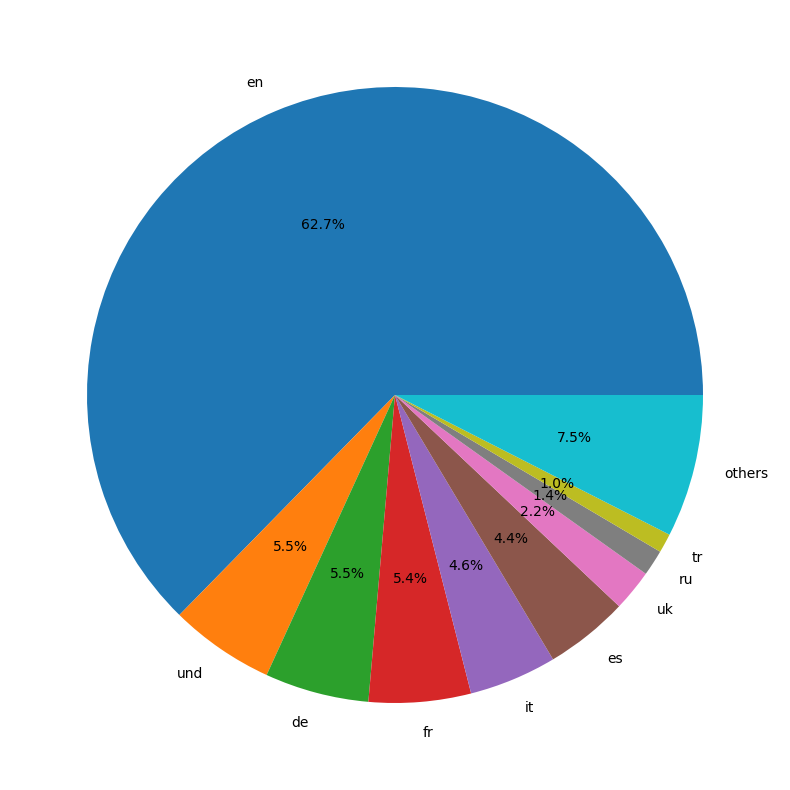

In [91]:
language_counts = [df_agg[la].sum() for la in selected_lang]
language_freq = np.array([la_co/sum(language_counts) for la_co in language_counts])
freqs = language_freq[language_freq > 0.01]
fig, ax = plt.subplots()
ax.pie(freqs, labels=selected_lang, autopct='%1.1f%%')
plt.show()

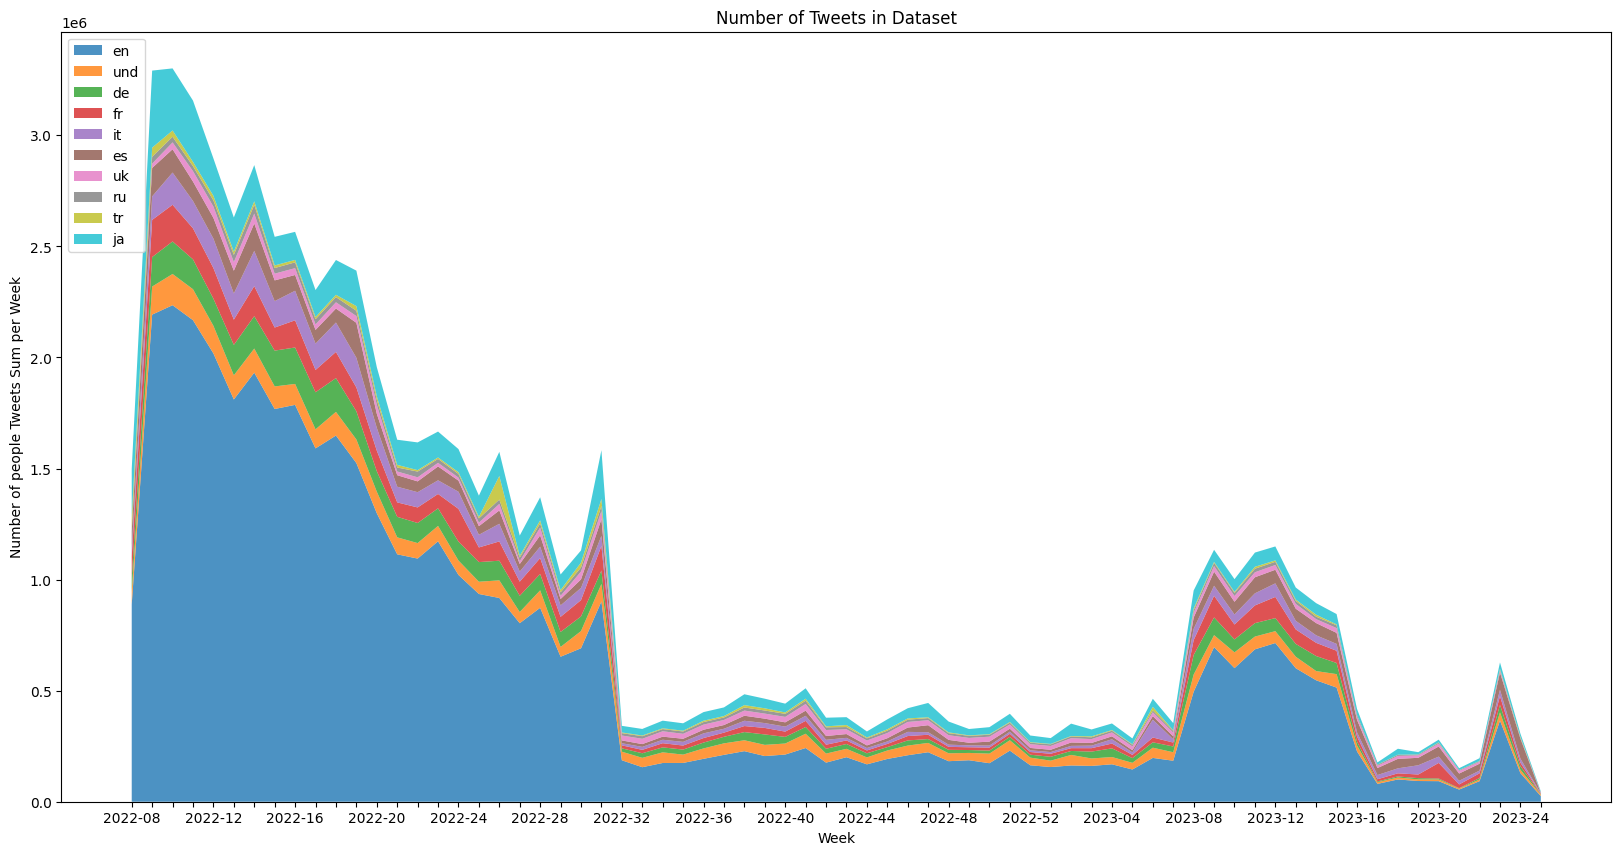

In [131]:

df_agg['weeks'] = df_agg['date'].apply(pd.to_datetime).apply(lambda x: str(x.year)+ "-" + str(x.week) if len(str(x.week))==2 else str(x.year)+ "-0" + str(x.week))


df_weeks = df_agg.groupby("weeks")[selected_lang].sum()


fig, ax = plt.subplots()
index=["" for _ in range(len(df_weeks.index))] 
index[::4]=list(df_weeks.index)[::4]
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ax.set_xticklabels(index)

ax.stackplot(df_weeks.index, [df_weeks[la] for la in selected_lang],
             labels=languages, alpha=0.8)


ax.legend(loc='upper left')
ax.set_title('Number of Tweets in Dataset')
ax.set_xlabel('Week')

ax.set_ylabel('Number of people Tweets Sum per Week')

plt.show()


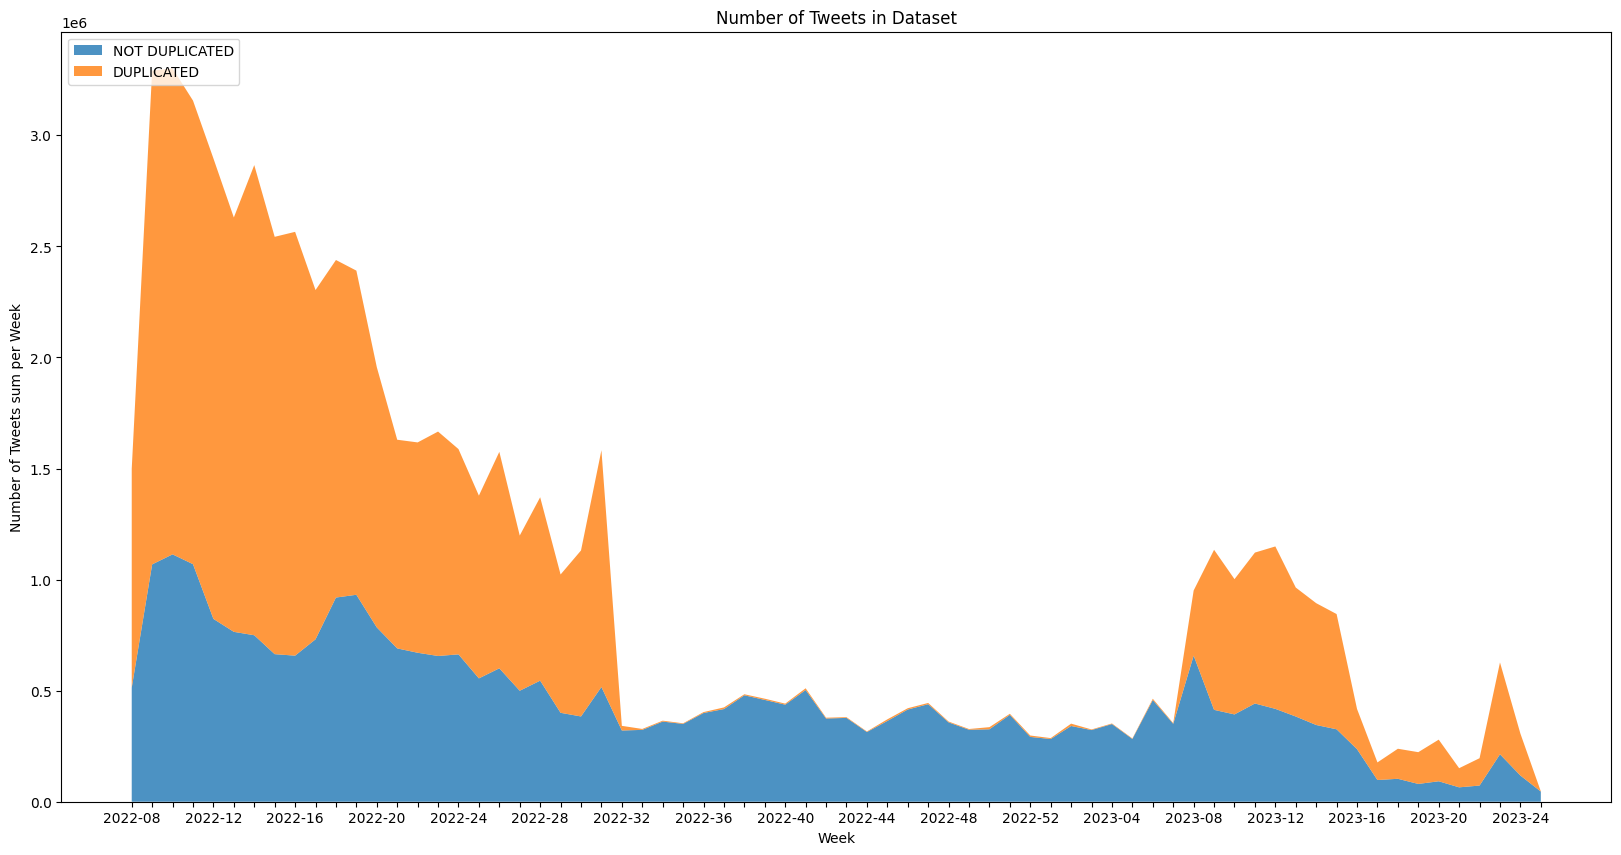

In [132]:



df_agg['weeks'] = df_agg['date'].apply(pd.to_datetime).apply(lambda x: str(x.year)+ "-" + str(x.week) if len(str(x.week))==2 else str(x.year)+ "-0" + str(x.week))

df_weeks = df_agg.groupby("weeks")[[DataSchema.ROWS, DataSchema.DUPLICATED]].sum()
df_weeks[DataSchema.ROWS] = df_weeks[DataSchema.ROWS] - df_weeks[DataSchema.DUPLICATED]



fig, ax = plt.subplots()
ax.stackplot(df_weeks.index, [df_weeks[DataSchema.ROWS], df_weeks[DataSchema.DUPLICATED]],
             labels=['NOT DUPLICATED', 'DUPLICATED'], alpha=0.8)

index=["" for _ in range(len(df_weeks.index))] 
index[::4]=list(df_weeks.index)[::4]


with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ax.set_xticklabels(index)
ax.legend(loc='upper left')
ax.set_title('Number of Tweets in Dataset')
ax.set_xlabel('Week')
ax.set_ylabel('Number of Tweets sum per Week')

plt.show()

Explanation:
[Link to Kaggle](https://www.kaggle.com/datasets/bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/data)

The creator of this dataset states the following:

[Aug 09]
Significant drop in tweets extracted, but I am now getting ORIGINAL/ NON-RETWEETS.

[Aug 08]
I've noticed that I had a spike of Tweets extracted, but they are literally thousands of retweets of a single original tweet. I also noticed that my crawlers seem to deviate because of this tactic being used by some Twitter users where they flood Twitter with tweets using a hashtag like "#Ukraine" but also add their own hashtag in it. Starting tomorrow, all the extracted data I will be pulling out of twitter will be NON RETWEETS. I will observe on what will be the effect on the total tweets per day for this config change. 

And:

[Feb 26]
I've started to pull in RETWEETS again, so I am expecting a significant amount of throughput in tweets again on top of the dedicated processes that I have that gets NONRETWEETS. If you don't want RETWEETS, just filter them out. 


Which explains the drop of duplicated tweets around 2022-32 and the increase around 2023-08.

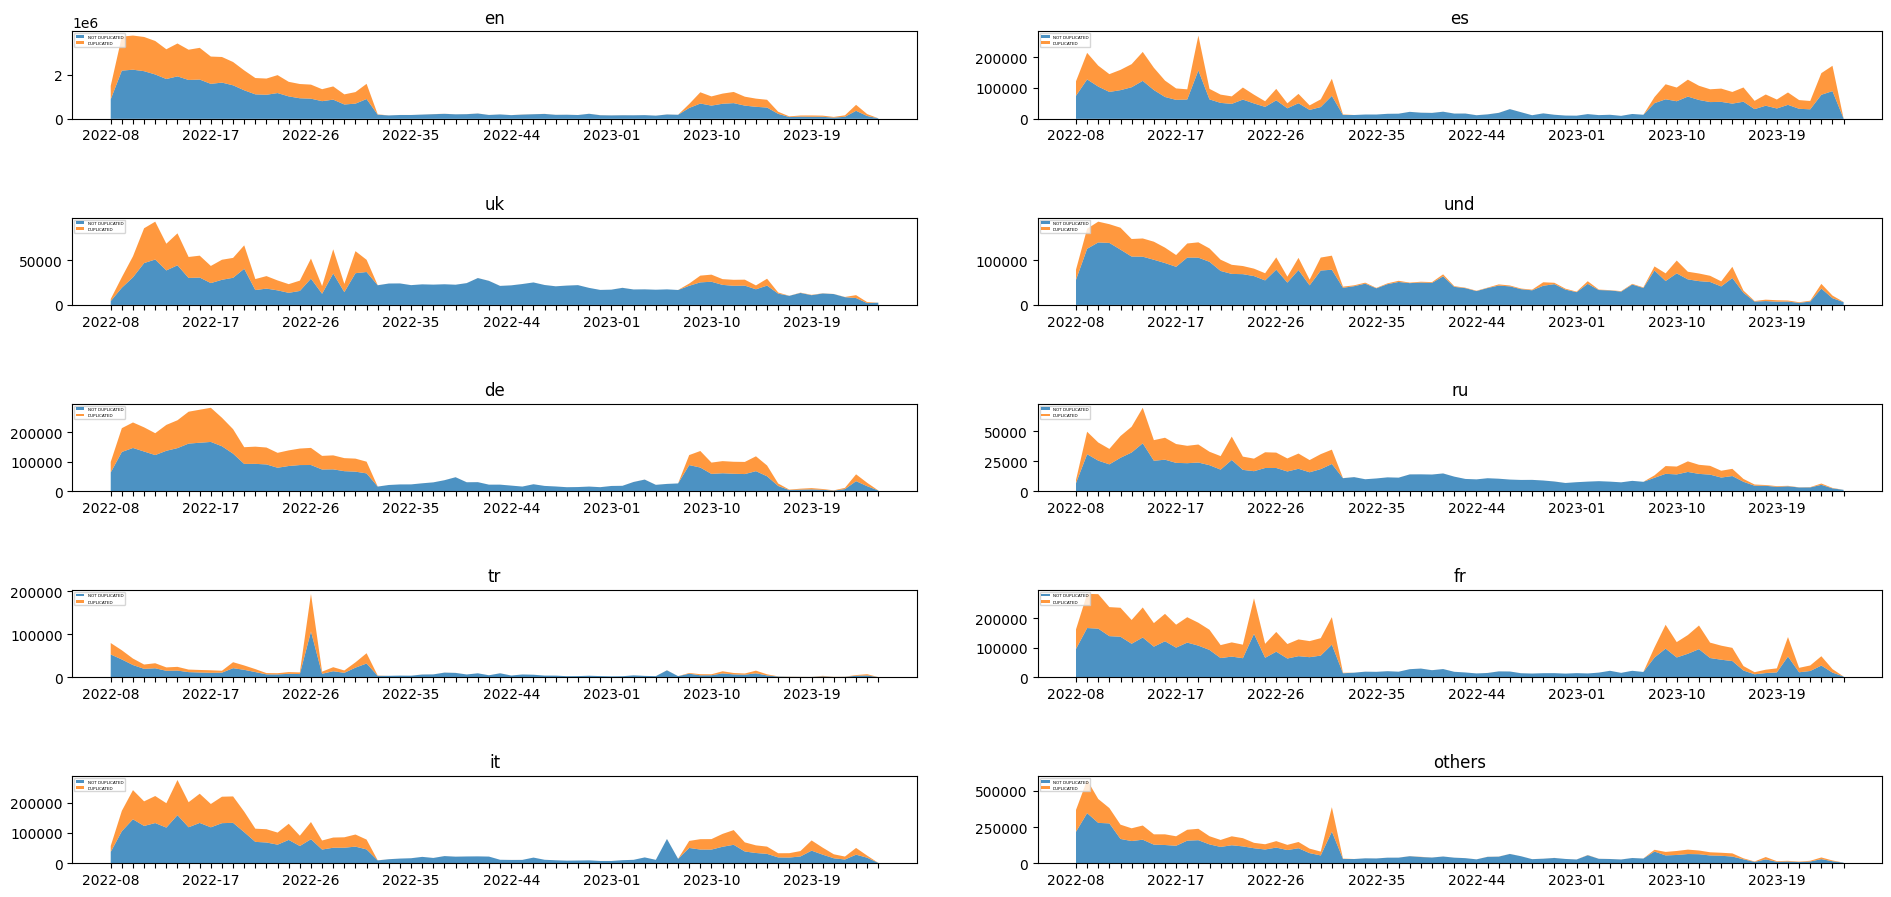

In [138]:
fig, ax = plt.subplots(5,2)
fig.tight_layout(pad=5.0)
for lang_index, language in enumerate(selected_lang):
    x_ind = lang_index % 5
    y_ind = lang_index % 2
    df_agg['weeks'] = df_agg['date'].apply(pd.to_datetime).apply(lambda x: str(x.year)+ "-" + str(x.week) if len(str(x.week))==2 else str(x.year)+ "-0" + str(x.week))
    
    df_weeks = df_agg.groupby("weeks")[[language,language+"_dupl"]].sum()
    df_weeks[DataSchema.ROWS] = df_weeks[language] - df_weeks[language+"_dupl"]
    
    
    
    
    ax[x_ind,y_ind].stackplot(df_weeks.index, [df_weeks[language], df_weeks[language+"_dupl"]],
                 labels=['NOT DUPLICATED', 'DUPLICATED'], alpha=0.8)
    
    index=["" for _ in range(len(index))] 
    index[::9]=list(df_weeks.index)[::9]

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        ax[x_ind,y_ind].set_xticklabels(index)#
    ax[x_ind,y_ind].legend(loc='upper left',fontsize="3")
    ax[x_ind,y_ind].set_title(f'{language}')

plt.show()

10